# Installing and importing modules

In [1]:
!pip install pyspark

In [2]:
!pip install pyarrow

In [3]:
!pip install yahoo_fin

In [4]:
!pip install lime

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas
import pandas_datareader as pdr
from pyspark.sql.functions import year, month, dayofmonth, col
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from pyspark.sql.functions import last, first, coalesce
from pyspark.sql.functions import col, max as max_, min as min_
from pyspark.sql.functions import year, month, dayofmonth, col
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.window import Window

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [6]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Data Collection

In [7]:
#Setting parameters for data collection

ticker = 'TSLA'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2023, 1, 1)
fred_symbols = ['UNRATE', 'GDP', 'FEDFUNDS', 'CPIAUCNS', 'M2', 'DGS10', 'PCE', 'T10Y2Y', 'USROA', 'USROE', 'WTISPLC', 'HOUST', 'INDPRO', 'PAYEMS', 'BAMLH0A0HYM2', 'GS10', 'BASE', 'RIFSPPFAAD01NB', 'EXUSEU', 'NETEXP']

In [8]:
#Calling APIs to gather information

historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [9]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

In [10]:
#Dataframe building
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())

In [11]:
print(historical_data_spark)


DataFrame[index: timestamp, open: double, high: double, low: double, close: double, adjclose: double, volume: bigint, ticker: string]


In [12]:
#Performing operations on dataframe through SparkSQL methods

historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))

historical_data_spark.show()

+-------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+
|               DATE|              open|              high|               low|             close|   volume|year|month|day|
+-------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+
|2010-06-29 00:00:00|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|281494500|2010|    6| 29|
|2010-06-30 00:00:00|1.7193330526351929|2.0280001163482666| 1.553333044052124|1.5886670351028442|257806500|2010|    6| 30|
|2010-07-01 00:00:00|1.6666669845581055|1.7280000448226929|1.3513330221176147|1.4639999866485596|123282000|2010|    7|  1|
|2010-07-02 00:00:00|1.5333329439163208|1.5399999618530273|  1.24733304977417|1.2799999713897705| 77097000|2010|    7|  2|
|2010-07-06 00:00:00|1.3333330154418945|1.3333330154418945|1.0553330183029175|1.0740000009536743|103003500|2010|    7|  6|
|2010-07-07 00:0

In [13]:
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
#fred_df_spark.show()

In [14]:
#Performing joining of the two dataframes on DATE, ordering and removing column

dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.drop("DATE")
dataset_spark.show()

+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|281494500|2010|    6| 29|   NaN|      NaN|     NaN|     NaN|   NaN| 2.97|    NaN|  2.36|  NaN|  NaN|    

In [15]:

row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)


Number of rows in the DataFrame:  3150


In [16]:
#Filling NaN values with the last non-null number

from pyspark.sql.window import Window
import pyspark.sql.functions as F

def forwardFillImputer(df, cols=[], partitioner="Index", value='NaN'):
    for c in cols:

        window_spec = Window.orderBy(partitioner)


        df = df.withColumn(c, F.when(F.col(c) != value, F.col(c)).otherwise(F.lit(None)))

        df = df.withColumn(c, F.last(c, True).over(window_spec))

    return df

In [17]:
dataset_spark = forwardFillImputer(dataset_spark, cols=[i for i in fred_symbols])
dataset_spark.show()

+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|281494500|2010|    6| 29|  NULL|     NULL|    NULL|    NULL|  NULL| 2.97|   NULL|  2.36| NULL| NULL|   N

In [18]:
# Drop rows where 'column1' or 'column2' have null values
dataset_spark = dataset_spark.dropna()
row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)

Number of rows in the DataFrame:  3142


# LSTM Construction

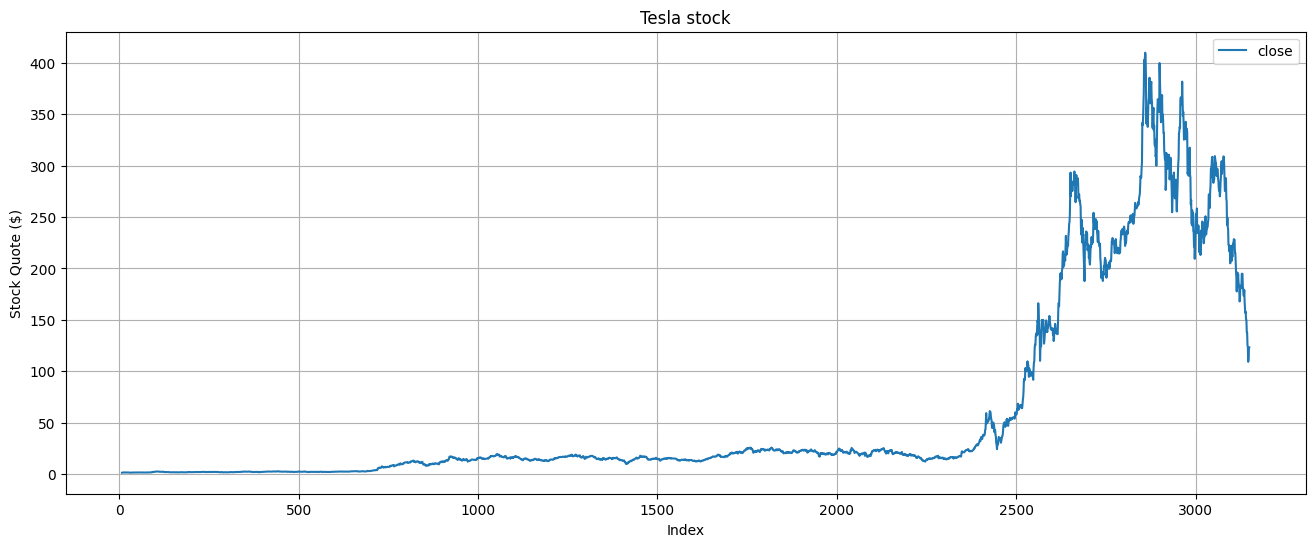

In [19]:
#Target Visualization
df_plot = dataset_spark.select('Index', 'close').toPandas()
df_plot.set_index('Index', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('Tesla stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [20]:

dataset_spark.toPandas().shape

(3142, 29)

## Data Preparation

In [21]:
# Prepare data for Processing
feature_columns = [col_name for col_name in dataset_spark.columns if col_name != 'close' and col_name != 'Index']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.9  # 90% for training, 10% for testing
split_point = int(dataset_spark.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark.limit(split_point)
test_data = dataset_spark.subtract(train_data)

In [22]:
# Features used for predictions
print(feature_columns)


['open', 'high', 'low', 'volume', 'year', 'month', 'day', 'UNRATE', 'GDP', 'FEDFUNDS', 'CPIAUCNS', 'M2', 'DGS10', 'PCE', 'T10Y2Y', 'USROA', 'USROE', 'WTISPLC', 'HOUST', 'INDPRO', 'PAYEMS', 'BAMLH0A0HYM2', 'GS10', 'BASE', 'RIFSPPFAAD01NB', 'EXUSEU', 'NETEXP']


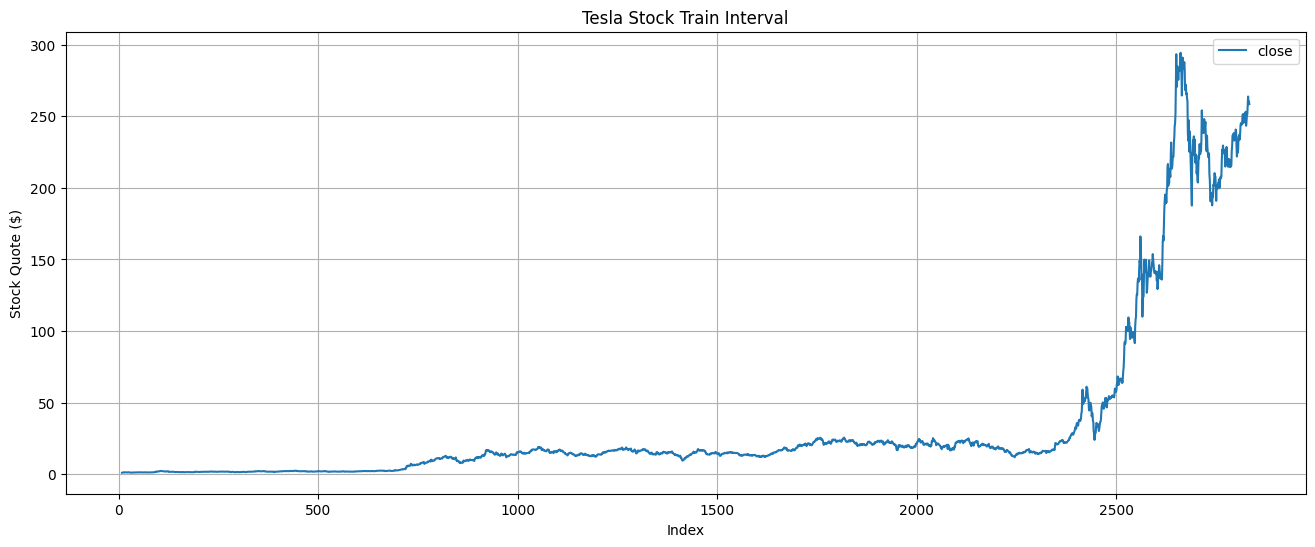

In [23]:
# Training split visualization
train_data_plot = train_data.select('Index', 'close').toPandas()
train_data_plot.set_index('Index', inplace=True)
train_data_plot.plot(figsize=(16, 6), grid=True)
plt.title('Tesla Stock Train Interval')
plt.ylabel('Stock Quote ($)')
plt.show()

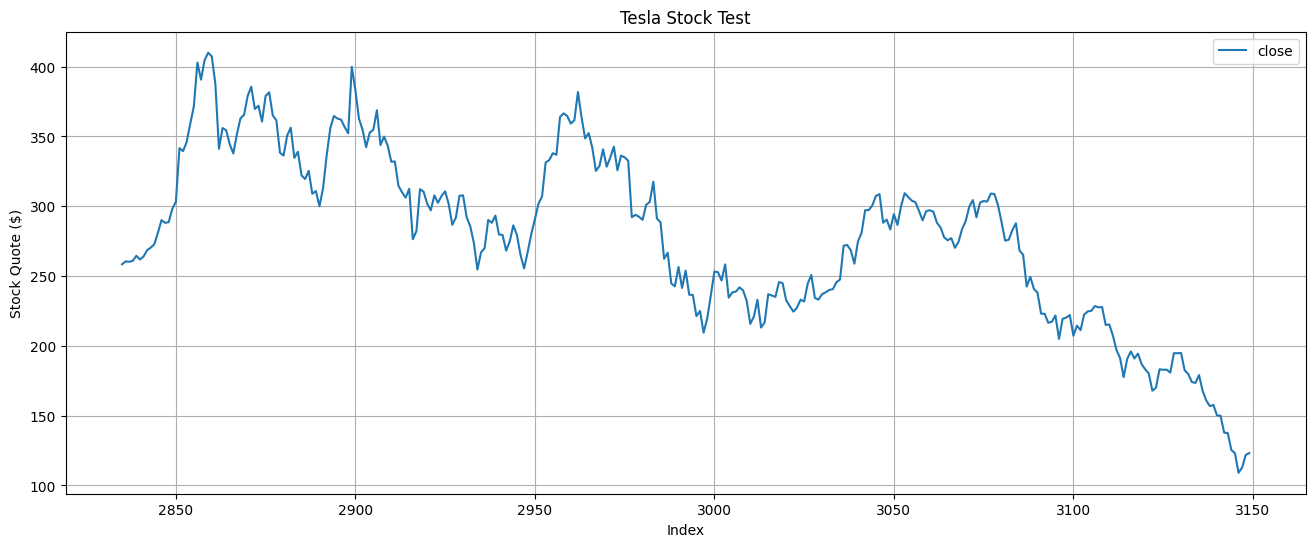

In [24]:
# Testing split visualization
test_data_plot = test_data.select('Index', 'close').toPandas()
test_data_plot.set_index('Index', inplace=True)
test_data_plot.plot(figsize=(16, 6), grid=True)
plt.title('Tesla Stock Test')
plt.ylabel('Stock Quote ($)')
plt.show()

In [25]:
# Set Building
import numpy as np
trainArray = np.array(train_data.select('*').collect())
testArray = np.array(test_data.select('*').collect())

In [26]:
print(trainArray[0])
print('-------------')
print(testArray[0])

[ 1.19666696e+00  1.20466697e+00  1.13333297e+00  1.13666701e+00
  3.30375000e+07  2.01000000e+03  7.00000000e+00  1.20000000e+01
  9.40000000e+00  1.51416070e+04  1.80000000e-01  2.18011000e+02
  8.60810000e+03  3.08000000e+00  1.02681000e+04  2.43000000e+00
  6.20000000e-01  5.79000000e+00  7.63700000e+01  5.46000000e+02
  9.22522000e+01  1.30420000e+05  6.85000000e+00  3.01000000e+00
  2.01242600e+03  1.90000000e-01  1.28110000e+00 -5.53943000e+02
  8.00000000e+00]
-------------
[ 2.59466675e+02  2.60260010e+02  2.54529999e+02  2.58406677e+02
  5.10942000e+07  2.02100000e+03  1.00000000e+01  1.00000000e+00
  4.50000000e+00  2.46546030e+04  8.00000000e-02  2.76589000e+02
  1.93708000e+04  1.48000000e+00  1.66138000e+04  1.21000000e+00
  5.60000000e-01  5.31000000e+00  8.14800000e+01  1.57200000e+03
  1.00304500e+02  1.48559000e+05  3.20000000e+00  1.58000000e+00
  3.38280000e+03  7.00000000e-02  1.16000000e+00 -9.24289000e+02
  2.83500000e+03]


In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
# Data Scaling
minMaxScale = MinMaxScaler()
minMaxScale.fit(trainArray)
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [29]:
print(testingArray[0])
print('--------------')
print(trainingArray[0])

[ 0.87275622  0.86661764  0.87559607  0.87737587  0.05405728  1.
  0.81818182  0.          0.08108108  1.09503801  0.01265823  1.04048029
  0.99626955  0.29721362  1.03505252  0.42372881  0.21359223  0.23516237
  0.69451278  0.89180051  0.80617776  0.85447639  0.02292994  0.32432432
  0.64245909  0.02469136  0.26947637 -0.08886461  1.00035386]
--------------
[1.26142177e-04 3.79137703e-05 2.30331434e-05 0.00000000e+00
 3.42648754e-02 0.00000000e+00 5.45454545e-01 3.66666667e-01
 5.22522523e-01 0.00000000e+00 5.48523207e-02 0.00000000e+00
 0.00000000e+00 7.92569659e-01 0.00000000e+00 8.37288136e-01
 2.71844660e-01 2.88913774e-01 6.39854530e-01 2.45139476e-02
 3.92874741e-01 3.79871500e-03 4.87898089e-01 8.07432432e-01
 1.82842427e-02 7.40740741e-02 5.78799489e-01 7.33654927e-01
 0.00000000e+00]


In [30]:
# Check Successful Scaling
print("Min:", trainingArray.min())
print("Max:", trainingArray.max())
print("Min:", trainingArray.min())
print("Max:", trainingArray.max())


Min: 0.0
Max: 1.0000000000000004
Min: 0.0
Max: 1.0000000000000004


In [31]:
#Extracting training and testing set
num_features = trainingArray.shape[1]

x_start = 0
x_end = 2
xtrain = trainingArray[:, x_start:x_end]

x_start = x_end
x_end = 3
xtrain = np.concatenate((xtrain, trainingArray[:, x_start:x_end]), axis=1)

x_start = 4
x_end = num_features
xtrain = np.concatenate((xtrain, trainingArray[:, x_start:x_end]), axis=1)


ytrain = trainingArray[:, 3:4]


# Same for test data
x_start = 0
x_end = 2
xtest = testingArray[:, x_start:x_end]

x_start = x_end
x_end = 3
xtest = np.concatenate((xtest, testingArray[:, x_start:x_end]), axis=1)

x_start = 4
x_end = num_features
xtest = np.concatenate((xtest, testingArray[:, x_start:x_end]), axis=1)

ytest = testingArray[:, 3:4]

In [32]:
trainingArray[0]

array([1.26142177e-04, 3.79137703e-05, 2.30331434e-05, 0.00000000e+00,
       3.42648754e-02, 0.00000000e+00, 5.45454545e-01, 3.66666667e-01,
       5.22522523e-01, 0.00000000e+00, 5.48523207e-02, 0.00000000e+00,
       0.00000000e+00, 7.92569659e-01, 0.00000000e+00, 8.37288136e-01,
       2.71844660e-01, 2.88913774e-01, 6.39854530e-01, 2.45139476e-02,
       3.92874741e-01, 3.79871500e-03, 4.87898089e-01, 8.07432432e-01,
       1.82842427e-02, 7.40740741e-02, 5.78799489e-01, 7.33654927e-01,
       0.00000000e+00])

In [33]:
xtrain[0]

array([1.26142177e-04, 3.79137703e-05, 2.30331434e-05, 3.42648754e-02,
       0.00000000e+00, 5.45454545e-01, 3.66666667e-01, 5.22522523e-01,
       0.00000000e+00, 5.48523207e-02, 0.00000000e+00, 0.00000000e+00,
       7.92569659e-01, 0.00000000e+00, 8.37288136e-01, 2.71844660e-01,
       2.88913774e-01, 6.39854530e-01, 2.45139476e-02, 3.92874741e-01,
       3.79871500e-03, 4.87898089e-01, 8.07432432e-01, 1.82842427e-02,
       7.40740741e-02, 5.78799489e-01, 7.33654927e-01, 0.00000000e+00])

In [34]:
ytrain[0]

array([0.])

In [35]:
print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (2827, 28)
xtest shape = (315, 28)
ytrain shape = (2827, 1)
ytest shape = (315, 1)


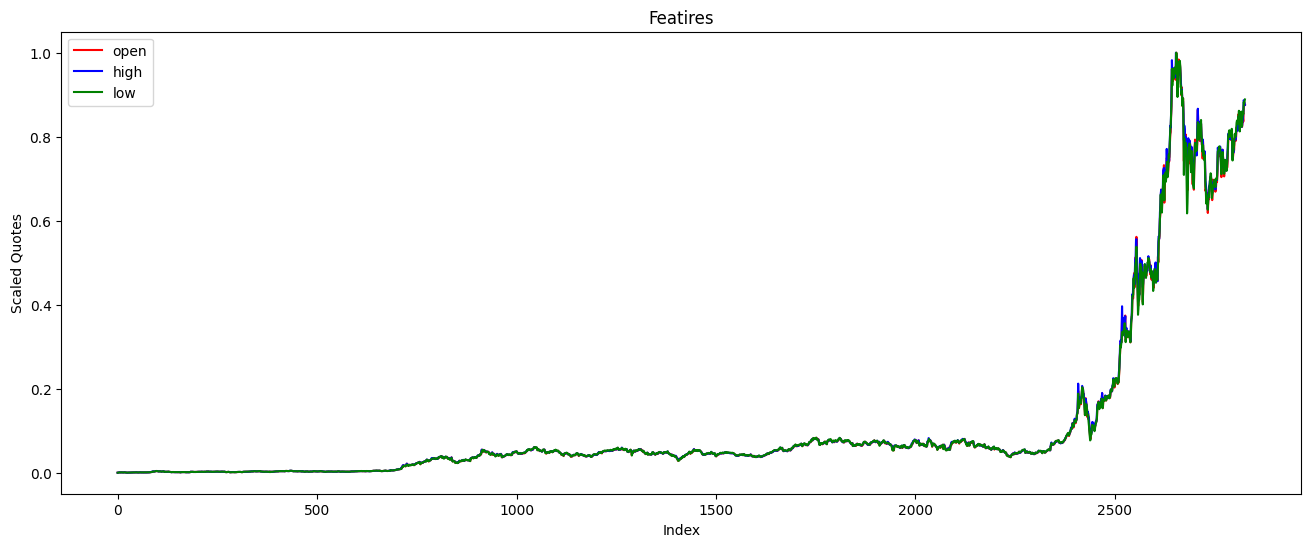

In [36]:
#Plotting indicators to check coherence
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
#plt.plot(xtrain[:,3],color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Featires')
plt.xlabel('Index')
plt.ylabel('Scaled Quotes')
plt.show()

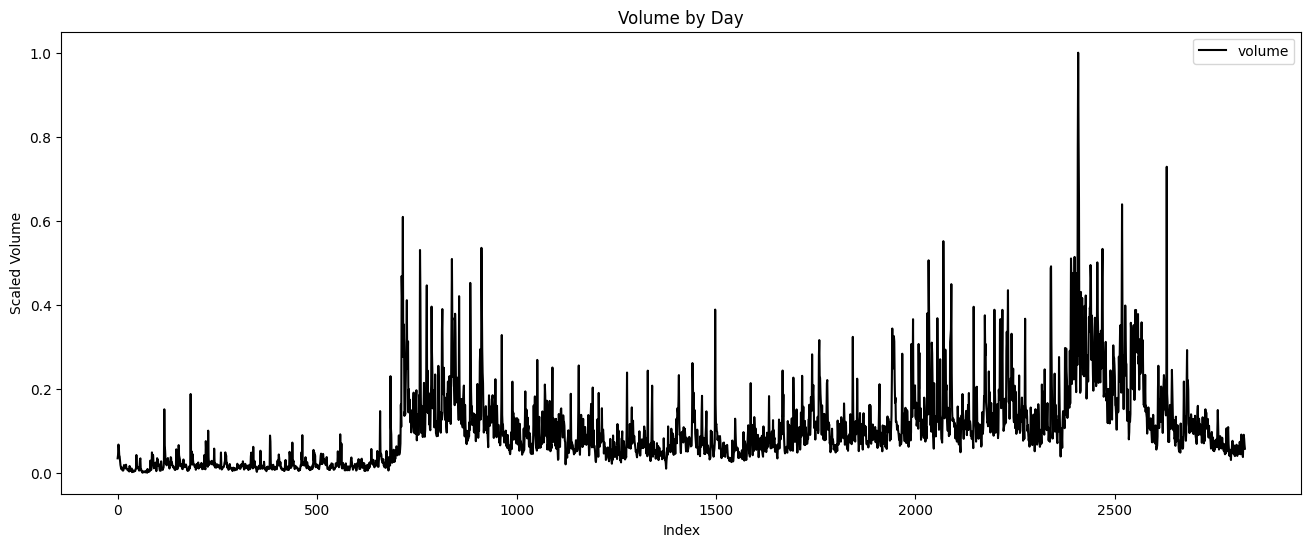

In [37]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,3],color='black', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Index')
plt.ylabel('Scaled Volume')
plt.show()

# Keras


In [38]:
from keras import models, layers
import tensorflow as tf

In [39]:
input_shape = (1, 28)


In [88]:
# LSTM
model = models.Sequential()
model.add(layers.LSTM(32, input_shape=input_shape,
                return_sequences=True))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(16))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [89]:
# LSTM for pattern capturing, Dropout for regularization
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1, 32)             7808      
                                                                 
 dropout_12 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_24 (LSTM)              (None, 16)                3136      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 10961 (42.82 KB)
Trainable params: 10961 (42.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
xtrain = xtrain.reshape((2827, 1, 28))
xtest  = xtest.reshape((315,1,28))

In [91]:
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

The shape of xtrain is (2827, 1, 28): 
The shape of xtest is (315, 1, 28): 


In [92]:
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

The shape of xtrain is (2827, 1, 28): 
The shape of xtest is (315, 1, 28): 


In [93]:
# Model Training
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=50)

Epoch 1/50
283/283 [==============================] - 4s 3ms/step - loss: 0.0086
Epoch 2/50
283/283 [==============================] - 1s 3ms/step - loss: 8.8500e-04
Epoch 3/50
283/283 [==============================] - 1s 4ms/step - loss: 6.7907e-04
Epoch 4/50
283/283 [==============================] - 1s 4ms/step - loss: 4.8227e-04
Epoch 5/50
283/283 [==============================] - 1s 3ms/step - loss: 6.1430e-04
Epoch 6/50
283/283 [==============================] - 1s 3ms/step - loss: 3.8350e-04
Epoch 7/50
283/283 [==============================] - 1s 3ms/step - loss: 4.1924e-04
Epoch 8/50
283/283 [==============================] - 1s 3ms/step - loss: 3.1823e-04
Epoch 9/50
283/283 [==============================] - 1s 3ms/step - loss: 3.6045e-04
Epoch 10/50
283/283 [==============================] - 1s 3ms/step - loss: 3.0940e-04
Epoch 11/50
283/283 [==============================] - 1s 3ms/step - loss: 2.8028e-04
Epoch 12/50
283/283 [==============================] - 1s 3ms/step 

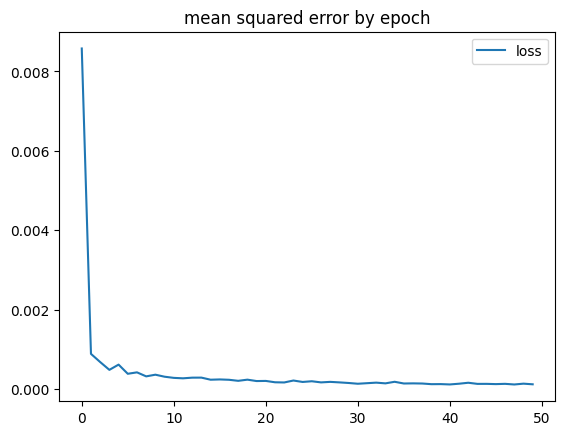

In [94]:
# MSE error visualization
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [95]:
# Test Prediction
predicted = model.predict(xtest)

10/10 [==============================] - 1s 2ms/step


In [96]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

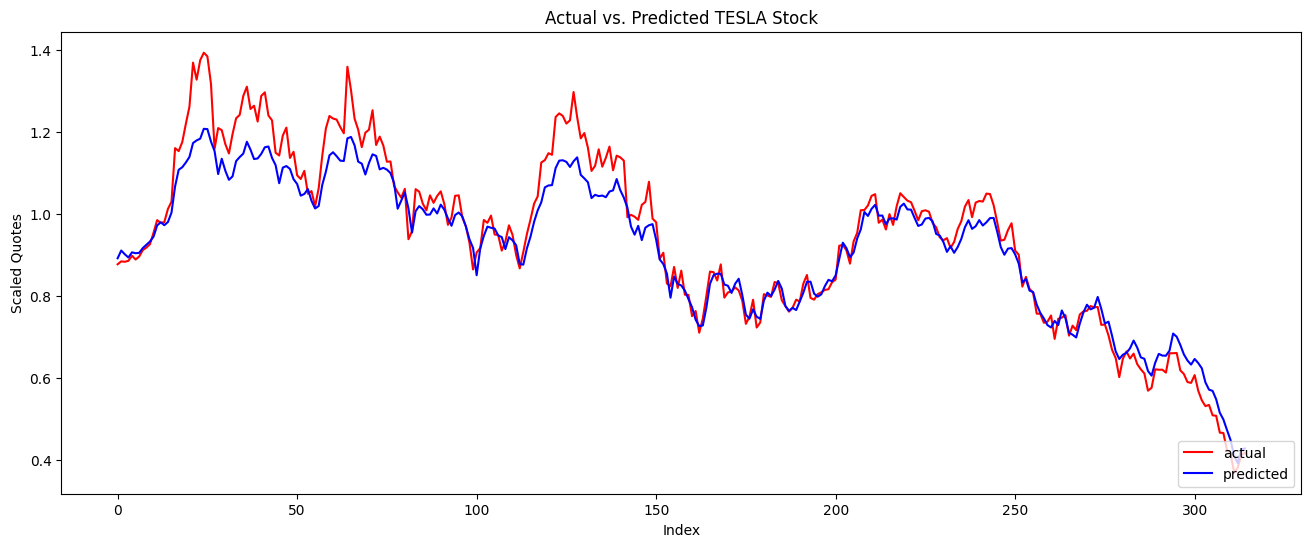

In [97]:
# Prediction Visualization
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs. Predicted TESLA Stock')
plt.xlabel('Index')
plt.ylabel('Scaled Quotes')
plt.show()

In [98]:
# RMSE
import sklearn.metrics as metrics
np.sqrt(metrics.mean_squared_error(ytest,predicted))

0.05698710969822189